# Graph Neural Network (Graph Autoencoder) for Daily-Shape Clustering
We build a k-NN graph of daily profiles and train a simple Graph Convolutional Autoencoder (no external libraries).
Then we cluster the learned node embeddings with KMeans.

In [1]:
import os, numpy as np, torch, torch.nn as nn, torch.optim as optim
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from nb_utils import load_eld_daily, evaluate_clustering, plot_tsne, save_outputs, seed_everything
seed_everything(42)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
DATA_PATH = '../data/LD2011_2014.txt'
OUT_DIR = '../results_gnn'
SAMPLE_SIZE = 2500  # keep graph manageable
K = 10              # k-NN
EPOCHS = 120
LR = 1e-3
EMB_DIM = 16
N_CLUSTERS = 5
X, meta = load_eld_daily(DATA_PATH, normalize='zscore', sample_size=SAMPLE_SIZE)
X.shape

(2500, 24)

### Build k-NN Graph (cosine similarity)

In [3]:

def build_knn_adjacency(X, k=10):
    S = cosine_similarity(X)  # dense NxN
    np.fill_diagonal(S, 0.0)
    # keep top-k neighbors per node
    N = S.shape[0]
    A = np.zeros_like(S)
    for i in range(N):
        idx = np.argpartition(S[i], -k)[-k:]
        A[i, idx] = 1.0
    # make undirected
    A = np.maximum(A, A.T)
    # Normalize with D^{-1/2} A D^{-1/2}
    deg = A.sum(axis=1) + 1e-8
    D_inv_sqrt = np.diag(1.0 / np.sqrt(deg))
    A_hat = D_inv_sqrt @ A @ D_inv_sqrt
    return A_hat.astype(np.float32)

A_hat = build_knn_adjacency(X, k=K)
A_hat_t = torch.tensor(A_hat, dtype=torch.float32, device=DEVICE)
X_t = torch.tensor(X, dtype=torch.float32, device=DEVICE)
A_hat.shape
    

(2500, 2500)

### Define a tiny GCN + inner-product decoder (Graph Autoencoder)

In [4]:

class GCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.W = nn.Linear(in_dim, out_dim, bias=False)
    def forward(self, X, A_hat):
        return torch.relu(A_hat @ self.W(X))

class GAE(nn.Module):
    def __init__(self, in_dim, emb_dim):
        super().__init__()
        self.gcn1 = GCNLayer(in_dim, 64)
        self.gcn2 = GCNLayer(64, emb_dim)
    def encode(self, X, A_hat):
        h1 = self.gcn1(X, A_hat)
        z = self.gcn2(h1, A_hat)
        return z
    def decode(self, Z):
        return torch.sigmoid(Z @ Z.t())  # inner-product decoder
    def forward(self, X, A_hat):
        Z = self.encode(X, A_hat)
        A_rec = self.decode(Z)
        return A_rec, Z

gae = GAE(in_dim=X.shape[1], emb_dim=EMB_DIM).to(DEVICE)
opt = optim.Adam(gae.parameters(), lr=LR)
bce = nn.BCELoss()
    

### Train Graph Autoencoder (reconstruct adjacency)

In [5]:

for epoch in range(1, EPOCHS+1):
    opt.zero_grad()
    A_rec, Z = gae(X_t, A_hat_t)
    loss = bce(A_rec, A_hat_t)
    loss.backward()
    opt.step()
    if epoch % 20 == 0 or epoch == 1:
        print(f"Epoch {epoch}/{EPOCHS}  BCE {loss.item():.5f}")
    

Epoch 1/120  BCE 0.87898
Epoch 20/120  BCE 0.69315
Epoch 40/120  BCE 0.69315
Epoch 60/120  BCE 0.69315
Epoch 80/120  BCE 0.69315
Epoch 100/120  BCE 0.69315
Epoch 120/120  BCE 0.69315


### Cluster embeddings & evaluate

GAE metrics: {'silhouette': -0.09444788098335266, 'davies_bouldin': 1.7607125706634286}


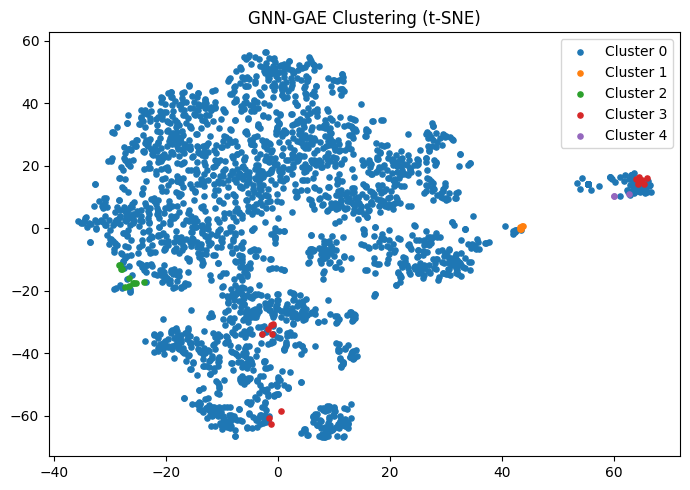

Saved to ../results_gnn


In [6]:
with torch.no_grad():
    Z = gae.encode(X_t, A_hat_t).cpu().numpy()
kmeans = KMeans(n_clusters=N_CLUSTERS, n_init=20, random_state=42)
labels = kmeans.fit_predict(Z)
metrics = evaluate_clustering(X, labels)
print('GAE metrics:', metrics)
plot_tsne(X, labels, title='GNN-GAE Clustering (t-SNE)', savepath=os.path.join(OUT_DIR, 'tsne_gnn.png'))
save_outputs(OUT_DIR, 'gnn_gae', labels, Z, metrics)
print('Saved to', OUT_DIR)

## Task: Quick EDA — inspect a few daily profiles

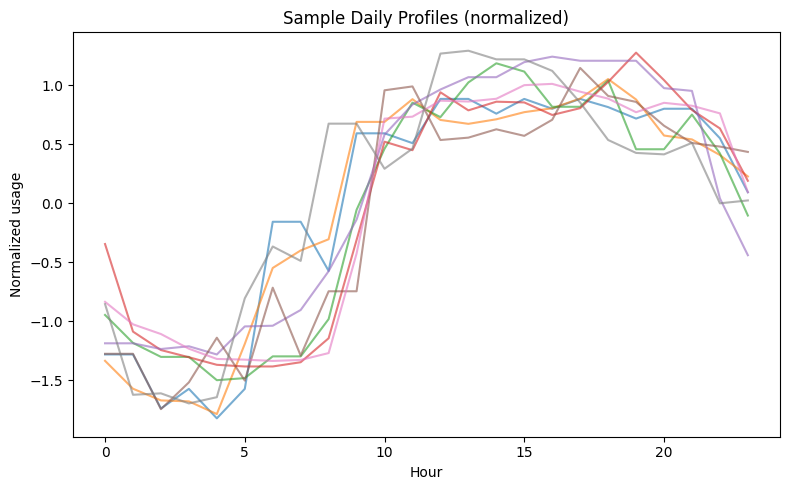

In [7]:
import numpy as np, matplotlib.pyplot as plt
idx = np.random.choice(len(X), size=min(8, len(X)), replace=False)
hours = np.arange(24)
plt.figure(figsize=(8,5))
for i in idx:
    plt.plot(hours, X[i], alpha=0.6)
plt.title('Sample Daily Profiles (normalized)')
plt.xlabel('Hour'); plt.ylabel('Normalized usage'); plt.tight_layout(); plt.show()

## Task: Cluster diagnostics — sizes, silhouettes, and mean profiles

Cluster sizes: [2465    5   11   16    3]


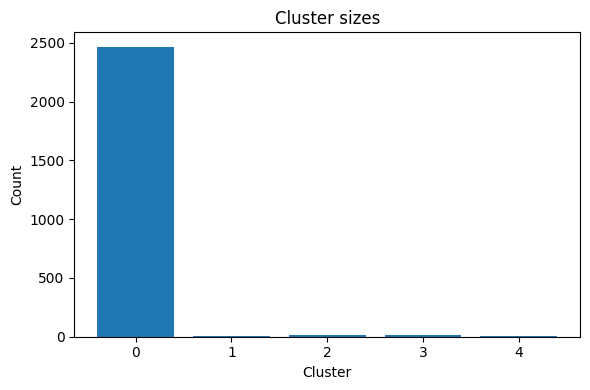

silhouette             
              mean median count
cluster                        
0           -0.098 -0.094  2465
1            0.623  0.622     5
2            0.453  0.443    11
3           -0.300 -0.270    16
4            0.445  0.457     3

In [8]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples
labels = np.asarray(labels)
K = len(np.unique(labels))
sizes = np.bincount(labels, minlength=K)
print('Cluster sizes:', sizes)

# Bar chart of cluster sizes
plt.figure(figsize=(6,4))
plt.bar(np.arange(K), sizes)
plt.xlabel('Cluster'); plt.ylabel('Count'); plt.title('Cluster sizes')
plt.tight_layout(); plt.show()

# Per-sample silhouettes, then per-cluster summary
sil_samples = silhouette_samples(X, labels)
df = pd.DataFrame({'cluster': labels, 'silhouette': sil_samples})
summary = df.groupby('cluster').agg(['mean','median','count']).round(3)
summary

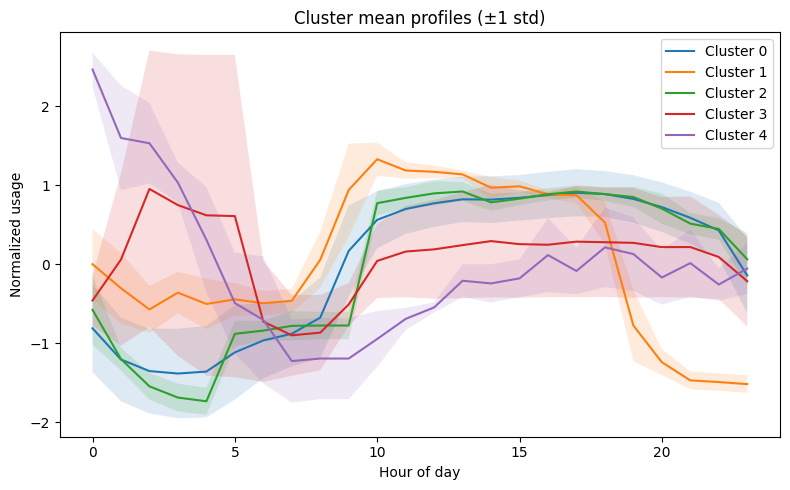

In [9]:
# Mean ± std 24h profile per cluster
hours = np.arange(24)
plt.figure(figsize=(8,5))
for k in range(K):
    Xk = X[labels==k]
    m = Xk.mean(axis=0)
    s = Xk.std(axis=0)
    plt.plot(hours, m, label=f'Cluster {k}')
    plt.fill_between(hours, m-s, m+s, alpha=0.15)
plt.xlabel('Hour of day'); plt.ylabel('Normalized usage')
plt.title('Cluster mean profiles (±1 std)')
plt.legend(); plt.tight_layout(); plt.show()

In [10]:
# Save a compact CSV summary (for report)
import os, json
summary_csv = summary.reset_index()
out_dir = OUT_DIR if 'OUT_DIR' in globals() else '.'
os.makedirs(out_dir, exist_ok=True)
summary_csv.to_csv(os.path.join(out_dir, 'cluster_summary.csv'), index=False)
print('Saved:', os.path.join(out_dir, 'cluster_summary.csv'))

Saved: ../results_gnn\cluster_summary.csv
